<a href="https://colab.research.google.com/github/NishaMDev/DL-Driver-DeepLearning/blob/main/CatchUp_1/DL_CatchUp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Recommenders: Quickstart



In this tutorial, we build a simple matrix factorization model using the [MovieLens 100K dataset](https://grouplens.org/datasets/movielens/100k/) with TFRS. We can use this model to recommend movies for a given user.

### Import TFRS

First, install and import TFRS:

In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

     |████████████████████████████████| 85 kB 2.3 MB/s 
     |████████████████████████████████| 462 kB 28.1 MB/s 
     |████████████████████████████████| 4.2 MB 12.2 MB/s 


In [ ]:
from typing import Dict, Text

import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

### Read the data

In [ ]:
# Ratings data.
ratings = tfds.load('movielens/100k-ratings', split="train")
# Features of all the available movies.
movies = tfds.load('movielens/100k-movies', split="train")

# Select the basic features.
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"]
})
movies = movies.map(lambda x: x["movie_title"])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-ratings/0.1.0.incomplete0MTW60/movielens-train.tfrecord*...…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.0. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1682 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-movies/0.1.0.incompleteEDLOE7/movielens-train.tfrecord*...:…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-movies/0.1.0. Subsequent calls will reuse this data.


Build vocabularies to convert user ids and movie titles into integer indices for embedding layers:

In [ ]:
user_ids_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
user_ids_vocabulary.adapt(ratings.map(lambda x: x["user_id"]))

movie_titles_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
movie_titles_vocabulary.adapt(movies)

### Define a model

We can define a TFRS model by inheriting from `tfrs.Model` and implementing the `compute_loss` method:

In [ ]:
class MovieLensModel(tfrs.Model):
  # We derive from a custom base class to help reduce boilerplate. Under the hood,
  # these are still plain Keras Models.

  def __init__(
      self,
      user_model: tf.keras.Model,
      movie_model: tf.keras.Model,
      task: tfrs.tasks.Retrieval):
    super().__init__()

    # Set up user and movie representations.
    self.user_model = user_model
    self.movie_model = movie_model

    # Set up a retrieval task.
    self.task = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # Define how the loss is computed.

    user_embeddings = self.user_model(features["user_id"])
    movie_embeddings = self.movie_model(features["movie_title"])

    return self.task(user_embeddings, movie_embeddings)

Define the two models and the retrieval task.

In [ ]:
# Define user and movie models.
user_model = tf.keras.Sequential([
    user_ids_vocabulary,
    tf.keras.layers.Embedding(user_ids_vocabulary.vocabulary_size(), 64)
])
movie_model = tf.keras.Sequential([
    movie_titles_vocabulary,
    tf.keras.layers.Embedding(movie_titles_vocabulary.vocabulary_size(), 64)
])

# Define your objectives.
task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
    movies.batch(128).map(movie_model)
  )
)


### Fit and evaluate it.

Create the model, train it, and generate predictions:



In [ ]:
# Create a retrieval model.
model = MovieLensModel(user_model, movie_model, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.5))

# Train for 3 epochs.
model.fit(ratings.batch(4096), epochs=3)

# Use brute-force search to set up retrieval using the trained representations.
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(
    movies.batch(100).map(lambda title: (title, model.movie_model(title))))

# Get some recommendations.
_, titles = index(np.array(["42"]))
print(f"Top 3 recommendations for user 42: {titles[0, :3]}")

Epoch 1/3
25/25 [==============================] - 9s 221ms/step - factorized_top_k/top_1_categorical_accuracy: 5.0000e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0015 - factorized_top_k/top_10_categorical_accuracy: 0.0046 - factorized_top_k/top_50_categorical_accuracy: 0.0426 - factorized_top_k/top_100_categorical_accuracy: 0.0974 - loss: 33075.3661 - regularization_loss: 0.0000e+00 - total_loss: 33075.3661
Epoch 2/3
25/25 [==============================] - 6s 222ms/step - factorized_top_k/top_1_categorical_accuracy: 8.0000e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0048 - factorized_top_k/top_10_categorical_accuracy: 0.0141 - factorized_top_k/top_50_categorical_accuracy: 0.1048 - factorized_top_k/top_100_categorical_accuracy: 0.2095 - loss: 31008.3143 - regularization_loss: 0.0000e+00 - total_loss: 31008.3143
Epoch 3/3
25/25 [==============================] - 6s 235ms/step - factorized_top_k/top_1_categorical_accuracy: 3.0000e-04 - factorized_top_k/top_5_categorica

# Multi-task recommenders


In the [basic retrieval tutorial](basic_retrieval) we built a retrieval system using movie watches as positive interaction signals.

In many applications, however, there are multiple rich sources of feedback to draw upon. For example, an e-commerce site may record user visits to product pages (abundant, but relatively low signal), image clicks, adding to cart, and, finally, purchases. It may even record post-purchase signals such as reviews and returns.

Integrating all these different forms of feedback is critical to building systems that users love to use, and that do not optimize for any one metric at the expense of overall performance.

In addition, building a joint model for multiple tasks may produce better results than building a number of task-specific models. This is especially true where some data is abundant (for example, clicks), and some data is sparse (purchases, returns, manual reviews). In those scenarios, a joint model may be able to use representations learned from the abundant task to improve its predictions on the sparse task via a phenomenon known as [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning). For example, [this paper](https://openreview.net/pdf?id=SJxPVcSonN) shows that a model predicting explicit user ratings from sparse user surveys can be substantially improved by adding an auxiliary task that uses abundant click log data.

In this tutorial, we are going to build a multi-objective recommender for Movielens, using both implicit (movie watches) and explicit signals (ratings).

## Imports


Let's first get our imports out of the way.


In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

In [ ]:
import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
import tensorflow_recommenders as tfrs

## Preparing the dataset

We're going to use the Movielens 100K dataset.

In [ ]:
ratings = tfds.load('movielens/100k-ratings', split="train")
movies = tfds.load('movielens/100k-movies', split="train")

# Select the basic features.
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
})
movies = movies.map(lambda x: x["movie_title"])

And repeat our preparations for building vocabularies and splitting the data into a train and a test set:

In [ ]:
# Randomly shuffle data and split between train and test.
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

## A multi-task model

There are two critical parts to multi-task recommenders:

1. They optimize for two or more objectives, and so have two or more losses.
2. They share variables between the tasks, allowing for transfer learning.

In this tutorial, we will define our models as before, but instead of having  a single task, we will have two tasks: one that predicts ratings, and one that predicts movie watches.

The user and movie models are as before:

```python
user_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_user_ids, mask_token=None),
  # We add 1 to account for the unknown token.
  tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

movie_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_movie_titles, mask_token=None),
  tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
])
```

However, now we will have two tasks. The first is the rating task:

```python
tfrs.tasks.Ranking(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)
```

Its goal is to predict the ratings as accurately as possible.

The second is the retrieval task:

```python
tfrs.tasks.Retrieval(
    metrics=tfrs.metrics.FactorizedTopK(
        candidates=movies.batch(128)
    )
)
```

As before, this task's goal is to predict which movies the user will or will not watch.

### Putting it together

We put it all together in a model class.

The new component here is that - since we have two tasks and two losses - we need to decide on how important each loss is. We can do this by giving each of the losses a weight, and treating these weights as hyperparameters. If we assign a large loss weight to the rating task, our model is going to focus on predicting ratings (but still use some information from the retrieval task); if we assign a large loss weight to the retrieval task, it will focus on retrieval instead.

In [ ]:
class MovielensModel(tfrs.models.Model):

  def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
    # We take the loss weights in the constructor: this allows us to instantiate
    # several model objects with different loss weights.

    super().__init__()

    embedding_dimension = 32

    # User and movie models.
    self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])
    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # A small model to take in user and movie embeddings and predict ratings.
    # We can make this as complicated as we want as long as we output a scalar
    # as our prediction.
    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    # The tasks.
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.movie_model)
        )
    )

    # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["user_id"])
    # And pick out the movie features and pass them into the movie model.
    movie_embeddings = self.movie_model(features["movie_title"])
    
    return (
        user_embeddings,
        movie_embeddings,
        # We apply the multi-layered rating model to a concatentation of
        # user and movie embeddings.
        self.rating_model(
            tf.concat([user_embeddings, movie_embeddings], axis=1)
        ),
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("user_rating")

    user_embeddings, movie_embeddings, rating_predictions = self(features)

    # We compute the loss for each task.
    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )
    retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)

    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss
            + self.retrieval_weight * retrieval_loss)

### Rating-specialized model

Depending on the weights we assign, the model will encode a different balance of the tasks. Let's start with a model that only considers ratings.

In [ ]:
model = MovielensModel(rating_weight=1.0, retrieval_weight=0.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [ ]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [ ]:
model.fit(cached_train, epochs=3)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/3
10/10 [==============================] - 7s 400ms/step - root_mean_squared_error: 2.0903 - factorized_top_k/top_1_categorical_accuracy: 2.6250e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0024 - factorized_top_k/top_10_categorical_accuracy: 0.0054 - factorized_top_k/top_50_categorical_accuracy: 0.0294 - factorized_top_k/top_100_categorical_accuracy: 0.0589 - loss: 4.0315 - regularization_loss: 0.0000e+00 - total_loss: 4.0315
Epoch 2/3
10/10 [==============================] - 4s 409ms/step - root_mean_squared_error: 1.1531 - factorized_top_k/top_1_categorical_accuracy: 1.8750e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0024 - factorized_top_k/top_10_categorical_accuracy: 0.0054 - factorized_top_k/top_50_categorical_accuracy: 0.0297 - factorized_top_k/top_100_categorical_accuracy: 0.0591 - loss: 1.3189 - regularization_loss: 0.0000e+00 - total_loss: 1.3189
Epoch 3/3
5/5 [==============================] - 3s 222ms/step - root_mean_squared_error: 1.1130 - factori

The model does OK on predicting ratings (with an RMSE of around 1.11), but performs poorly at predicting which movies will be watched or not: its accuracy at 100 is almost 4 times worse than a model trained solely to predict watches.

### Retrieval-specialized model

Let's now try a model that focuses on retrieval only.

In [ ]:
model = MovielensModel(rating_weight=0.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [ ]:
model.fit(cached_train, epochs=3)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/3
10/10 [==============================] - 5s 351ms/step - root_mean_squared_error: 3.7238 - factorized_top_k/top_1_categorical_accuracy: 7.5000e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0014 - factorized_top_k/top_10_categorical_accuracy: 0.0041 - factorized_top_k/top_50_categorical_accuracy: 0.0473 - factorized_top_k/top_100_categorical_accuracy: 0.1135 - loss: 69818.0291 - regularization_loss: 0.0000e+00 - total_loss: 69818.0291
Epoch 2/3
10/10 [==============================] - 4s 356ms/step - root_mean_squared_error: 3.7495 - factorized_top_k/top_1_categorical_accuracy: 0.0011 - factorized_top_k/top_5_categorical_accuracy: 0.0116 - factorized_top_k/top_10_categorical_accuracy: 0.0268 - factorized_top_k/top_50_categorical_accuracy: 0.1425 - factorized_top_k/top_100_categorical_accuracy: 0.2658 - loss: 67473.2891 - regularization_loss: 0.0000e+00 - total_loss: 67473.2891
Epoch 3/3
5/5 [==============================] - 1s 208ms/step - root_mean_squared_error: 3.77

We get the opposite result: a model that does well on retrieval, but poorly on predicting ratings.

### Joint model

Let's now train a model that assigns positive weights to both tasks.

In [ ]:
model = MovielensModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [ ]:
model.fit(cached_train, epochs=3)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/3
10/10 [==============================] - 5s 353ms/step - root_mean_squared_error: 2.5007 - factorized_top_k/top_1_categorical_accuracy: 3.7500e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0014 - factorized_top_k/top_10_categorical_accuracy: 0.0043 - factorized_top_k/top_50_categorical_accuracy: 0.0450 - factorized_top_k/top_100_categorical_accuracy: 0.1102 - loss: 69811.8274 - regularization_loss: 0.0000e+00 - total_loss: 69811.8274
Epoch 2/3
10/10 [==============================] - 4s 354ms/step - root_mean_squared_error: 1.2097 - factorized_top_k/top_1_categorical_accuracy: 9.8750e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0110 - factorized_top_k/top_10_categorical_accuracy: 0.0255 - factorized_top_k/top_50_categorical_accuracy: 0.1385 - factorized_top_k/top_100_categorical_accuracy: 0.2605 - loss: 67481.2713 - regularization_loss: 0.0000e+00 - total_loss: 67481.2713
Epoch 3/3
5/5 [==============================] - 1s 212ms/step - root_mean_squared_error: 

The result is a model that performs roughly as well on both tasks as each specialized model.

### Making prediction

We can use the trained multitask model to get trained user and movie embeddings, as well as the predicted rating:

In [ ]:
trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
      "user_id": np.array(["42"]),
      "movie_title": np.array(["Dances with Wolves (1990)"])
  })
print("Predicted rating:")
print(predicted_rating)

Predicted rating:
tf.Tensor([[3.4022596]], shape=(1, 1), dtype=float32)


While the results here do not show a clear accuracy benefit from a joint model in this case, multi-task learning is in general an extremely useful tool. We can expect better results when we can transfer knowledge from a data-abundant task (such as clicks) to a closely related data-sparse task (such as purchases).

# Deep & Cross Network (DCN)


This tutorial demonstrates how to use Deep & Cross Network (DCN) to effectively learn feature crosses.

##Background

**What are feature crosses and why are they important?** Imagine that we are building a recommender system to sell a blender to customers. Then, a customer's past purchase history such as `purchased_bananas` and `purchased_cooking_books`, or geographic features, are single features. If one has purchased both bananas **and** cooking books, then this customer will more likely click on the recommended blender. The combination of `purchased_bananas` and `purchased_cooking_books` is referred to as a **feature cross**, which provides additional interaction information beyond the individual features.
<div>
<center>
<img src="http://drive.google.com/uc?export=view&id=1e8pYZHM1ZSwqBLYVkKDoGg0_2t2UPc2y" width="600"/>
</center>
</div>




**What are the challenges in learning feature crosses?** In Web-scale applications, data are mostly categorical, leading to large and sparse feature space. Identifying effective feature crosses in this setting often requires
manual feature engineering or exhaustive search. Traditional feed-forward multilayer perceptron (MLP) models are universal function approximators; however, they cannot efficiently approximate even 2nd or 3rd-order feature crosses [[1](https://arxiv.org/pdf/2008.13535.pdf), [2](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/18fa88ad519f25dc4860567e19ab00beff3f01cb.pdf)].

**What is Deep & Cross Network (DCN)?** DCN was designed to learn explicit and bounded-degree cross features more effectively. It starts with an input layer (typically an embedding layer), followed by a *cross network* containing multiple cross layers that models explicit feature interactions, and then combines
with a *deep network* that models implicit feature interactions.


*   Cross Network. This is the core of DCN. It explicitly applies feature crossing at each layer, and the highest
polynomial degree increases with layer depth. The following figure shows the $(i+1)$-th cross layer.
<div class="fig figcenter fighighlight">
<center>
  <img src="http://drive.google.com/uc?export=view&id=1QvIDptMxixFNp6P4bBqMN4AYAhAIAYQZ" width="50%" style="display:block">
  </center>
</div>
*   Deep Network. It is a traditional feedforward multilayer perceptron (MLP).

The deep network and cross network are then combined to form DCN [[1](https://arxiv.org/pdf/2008.13535.pdf)]. Commonly, we could stack a deep network on top of the cross network (stacked structure); we could also place them in parallel (parallel structure). 


<div class="fig figcenter fighighlight">
<center>
  <img src="http://drive.google.com/uc?export=view&id=1WtDUCV6b-eetUnWVCAmcPh8mJFut5EUd" hspace="40" width="30%" style="margin: 0px 100px 0px 0px;">
  <img src="http://drive.google.com/uc?export=view&id=1xo_twKb847hasfss7JxF0UtFX_rEb4nt" width="20%">
  </center>
</div>

In the following, we will first show the advantage of DCN with a toy example, and then we will walk you through some common ways to utilize DCN using the MovieLen-1M dataset.

Let's first install and import the necessary packages for this colab.


In [ ]:
import pprint

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow_recommenders as tfrs

## Toy Example
To illustrate the benefits of DCN, let's work through a simple example. Suppose we have a dataset where we're trying to model the likelihood of a customer clicking on a blender Ad, with its features and label described as follows.

| Features / Label        | Description           | Value Type / Range  |
| ------------- |-------------| -----|
| $x_1$ = country | the country this customer lives in | Int in [0, 199] |
| $x_2$ = bananas | # bananas the customer has purchased |Int in   [0, 23] |
| $x_3$ = cookbooks | # cooking books the customer has purchased     |Int in  [0, 5] |
| $y$ | the likelihood of clicking on a blender Ad     |   -- |

Then, we let the data follow the following underlying distribution:
$$y = f(x_1, x_2, x_3) = 0.1x_1 + 0.4x_2+0.7x_3 + 0.1x_1x_2+3.1x_2x_3+0.1x_3^2$$

where the likelihood $y$ depends linearly both on features $x_i$'s, but also on multiplicative interactions between the $x_i$'s. In our case, we would say that the likelihood of purchasing a blender ($y$) depends not just on buying bananas ($x_2$) or cookbooks ($x_3$), but also on buying bananas and cookbooks *together* ($x_2x_3$).

We can generate the data for this as follows:


### Synthetic data generation

We first define $f(x_1, x_2, x_3)$ as described above. 

In [ ]:
def get_mixer_data(data_size=100_000, random_seed=42):
  # We need to fix the random seed
  # to make colab runs repeatable.
  rng = np.random.RandomState(random_seed)
  country = rng.randint(200, size=[data_size, 1]) / 200.
  bananas = rng.randint(24, size=[data_size, 1]) / 24.
  cookbooks = rng.randint(6, size=[data_size, 1]) / 6.

  x = np.concatenate([country, bananas, cookbooks], axis=1)

  # # Create 1st-order terms.
  y = 0.1 * country + 0.4 * bananas + 0.7 * cookbooks

  # Create 2nd-order cross terms.
  y += 0.1 * country * bananas + 3.1 * bananas * cookbooks + (
        0.1 * cookbooks * cookbooks)

  return x, y

Let's generate the data that follows the distribution, and split the data into 90% for training and 10% for testing.

In [ ]:
x, y = get_mixer_data()
num_train = 90000
train_x = x[:num_train]
train_y = y[:num_train]
eval_x = x[num_train:]
eval_y = y[num_train:]

### Model construction

We're going to try out both cross network and deep network to illustrate the advantage a cross network can bring to recommenders. As the data we just created only contains 2nd-order feature interactions, it would be sufficient to illustrate with a single-layered cross network. If we wanted to model higher-order feature interactions, we could stack multiple cross layers and use a multi-layered cross network. The two models we will be building are:
1.   Cross Network with only one cross layer;
2.   Deep Network with wider and deeper ReLU layers. 

We first build a unified model class whose loss is the mean squared error. 

In [ ]:
class Model(tfrs.Model):

  def __init__(self, model):
    super().__init__()
    self._model = model
    self._logit_layer = tf.keras.layers.Dense(1)

    self.task = tfrs.tasks.Ranking(
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=[
        tf.keras.metrics.RootMeanSquaredError("RMSE")
      ]
    )

  def call(self, x):
    x = self._model(x)
    return self._logit_layer(x)

  def compute_loss(self, features, training=False):
    x, labels = features
    scores = self(x)

    return self.task(
        labels=labels,
        predictions=scores,
    )

Then, we specify the cross network (with 1 cross layer of size 3) and the ReLU-based DNN (with layer sizes [512, 256, 128]):

In [ ]:
crossnet = Model(tfrs.layers.dcn.Cross())
deepnet = Model(
    tf.keras.Sequential([
      tf.keras.layers.Dense(512, activation="relu"),
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(128, activation="relu")
    ])
)

### Model training
Now that we have the data and models ready, we are going to train the models. We first shuffle and batch the data to prepare for model training.


In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(1000)
eval_data = tf.data.Dataset.from_tensor_slices((eval_x, eval_y)).batch(1000)

Then, we define the number of epochs as well as the learning rate.

In [ ]:
epochs = 100
learning_rate = 0.4

Alright, everything is ready now and let's compile and train the models. You could set `verbose=True` if you want to see how the model progresses.

In [ ]:
crossnet.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate))
crossnet.fit(train_data, epochs=epochs, verbose=False)

In [ ]:
deepnet.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate))
deepnet.fit(train_data, epochs=epochs, verbose=False)

### Model evaluation
We verify the model performance on the evaluation dataset and report the Root Mean Squared Error (RMSE, the lower the better).

In [ ]:
crossnet_result = crossnet.evaluate(eval_data, return_dict=True, verbose=False)
print(f"CrossNet(1 layer) RMSE is {crossnet_result['RMSE']:.4f} "
      f"using {crossnet.count_params()} parameters.")

deepnet_result = deepnet.evaluate(eval_data, return_dict=True, verbose=False)
print(f"DeepNet(large) RMSE is {deepnet_result['RMSE']:.4f} "
      f"using {deepnet.count_params()} parameters.")

CrossNet(1 layer) RMSE is 0.0007 using 16 parameters.
DeepNet(large) RMSE is 0.0582 using 166401 parameters.


We see that the cross network achieved **magnitudes lower RMSE** than a ReLU-based DNN, with **magnitudes fewer parameters**. This has suggested the efficieny of a cross network in learning feaure crosses.  

### Model understanding
We already know what feature crosses are important in our data, it would be fun to check whether our model has indeed learned the important feature cross. This can be done by visualizing the learned weight matrix in DCN. The weight $W_{ij}$ represents the learned importance of interaction between feature $x_i$ and $x_j$.

<Figure size 648x648 with 0 Axes>

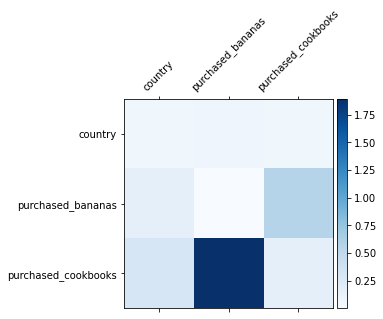

In [ ]:
mat = crossnet._model._dense.kernel
features = ["country", "purchased_bananas", "purchased_cookbooks"]

plt.figure(figsize=(9,9))
im = plt.matshow(np.abs(mat.numpy()), cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([''] + features, rotation=45, fontsize=10)
_ = ax.set_yticklabels([''] + features, fontsize=10)

Darker colours represent stronger learned interactions - in this case, it's clear that the model learned that purchasing babanas and cookbooks together is important.

If you are interested in trying out more complicated synthetic data, feel free to check out [this paper](https://arxiv.org/pdf/2008.13535.pdf).

## Movielens 1M example
We now examine the effectiveness of DCN on a real-world dataset: Movielens 1M [[3](https://grouplens.org/datasets/movielens)]. Movielens 1M is a popular dataset for recommendation research. It predicts users' movie ratings given user-related features and movie-related features. We use this dataset to demonstrate some common ways to utilize DCN.

### Data processing

The data processing procedure follows a similar procedure as the [basic ranking tutorial](https://www.tensorflow.org/recommenders/examples/basic_ranking).

In [ ]:
ratings = tfds.load("movie_lens/100k-ratings", split="train")
ratings = ratings.map(lambda x: {
    "movie_id": x["movie_id"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
    "user_gender": int(x["user_gender"]),
    "user_zip_code": x["user_zip_code"],
    "user_occupation_text": x["user_occupation_text"],
    "bucketized_user_age": int(x["bucketized_user_age"]),
})

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movie_lens/100k-ratings/0.1.0.incompleteO8AQAZ/movie_lens-train.tfrecord*.…

Dataset movie_lens downloaded and prepared to /root/tensorflow_datasets/movie_lens/100k-ratings/0.1.0. Subsequent calls will reuse this data.


Next, we randomly split the data into 80% for training and 20% for testing.


In [ ]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

Then, we create vocabulary for each feature.

In [ ]:
feature_names = ["movie_id", "user_id", "user_gender", "user_zip_code",
                 "user_occupation_text", "bucketized_user_age"]

vocabularies = {}

for feature_name in feature_names:
  vocab = ratings.batch(1_000_000).map(lambda x: x[feature_name])
  vocabularies[feature_name] = np.unique(np.concatenate(list(vocab)))

### Model construction

The model architecture we will be building starts with an embedding layer, which is fed into a cross network followed by a deep network. The embedding dimension is set to 32 for all the features. You could also use different embedding sizes for different features.

In [ ]:
class DCN(tfrs.Model):

  def __init__(self, use_cross_layer, deep_layer_sizes, projection_dim=None):
    super().__init__()

    self.embedding_dimension = 32

    str_features = ["movie_id", "user_id", "user_zip_code",
                    "user_occupation_text"]
    int_features = ["user_gender", "bucketized_user_age"]

    self._all_features = str_features + int_features
    self._embeddings = {}

    # Compute embeddings for string features.
    for feature_name in str_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.StringLookup(
              vocabulary=vocabulary, mask_token=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])
      
    # Compute embeddings for int features.
    for feature_name in int_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.IntegerLookup(
              vocabulary=vocabulary, mask_value=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])

    if use_cross_layer:
      self._cross_layer = tfrs.layers.dcn.Cross(
          projection_dim=projection_dim,
          kernel_initializer="glorot_uniform")
    else:
      self._cross_layer = None

    self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
      for layer_size in deep_layer_sizes]

    self._logit_layer = tf.keras.layers.Dense(1)

    self.task = tfrs.tasks.Ranking(
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE")]
    )

  def call(self, features):
    # Concatenate embeddings
    embeddings = []
    for feature_name in self._all_features:
      embedding_fn = self._embeddings[feature_name]
      embeddings.append(embedding_fn(features[feature_name]))

    x = tf.concat(embeddings, axis=1)

    # Build Cross Network
    if self._cross_layer is not None:
      x = self._cross_layer(x)
    
    # Build Deep Network
    for deep_layer in self._deep_layers:
      x = deep_layer(x)

    return self._logit_layer(x)

  def compute_loss(self, features, training=False):
    labels = features.pop("user_rating")
    scores = self(features)
    return self.task(
        labels=labels,
        predictions=scores,
    )

### Model training
We shuffle, batch and cache the training and test data. 


In [ ]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

Let's define a function that runs a model multiple times and returns the model's RMSE mean and standard deviation out of multiple runs.

In [ ]:
def run_models(use_cross_layer, deep_layer_sizes, projection_dim=None, num_runs=5):
  models = []
  rmses = []

  for i in range(num_runs):
    model = DCN(use_cross_layer=use_cross_layer,
                deep_layer_sizes=deep_layer_sizes,
                projection_dim=projection_dim)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
    models.append(model)

    model.fit(cached_train, epochs=epochs, verbose=False)
    metrics = model.evaluate(cached_test, return_dict=True)
    rmses.append(metrics["RMSE"])

  mean, stdv = np.average(rmses), np.std(rmses)

  return {"model": models, "mean": mean, "stdv": stdv}

We set some hyper-parameters for the models. Note that these hyper-parameters are set globally for all the models for demonstration purpose. If you want to obtain the best performance for each model, or conduct a fair comparison among models, then we'd suggest you to fine-tune the hyper-parameters. Remember that the model architecture and optimization schemes are intertwined.

In [ ]:
epochs = 8
learning_rate = 0.01

**DCN (stacked).** We first train a DCN model with a stacked structure, that is, the inputs are fed to a cross network followed by a deep network.
<div>
<center>
<img src="http://drive.google.com/uc?export=view&id=1X8qoMtIYKJz4yBYifvfw4QpAwrjr70e_" width="140"/>
</center>
</div>


In [ ]:
dcn_result = run_models(use_cross_layer=True,
                        deep_layer_sizes=[192, 192])

5/5 [==============================] - 0s 4ms/step - RMSE: 0.9339 - loss: 0.8729 - regularization_loss: 0.0000e+00 - total_loss: 0.8729


**Low-rank DCN.** To reduce the training and serving cost, we leverage low-rank techniques to approximate the DCN weight matrices. The rank is passed in through argument `projection_dim`; a smaller `projection_dim` results in a lower cost. Note that `projection_dim` needs to be smaller than (input size)/2 to reduce the cost. In practice, we've observed using low-rank DCN with rank (input size)/4 consistently preserved the accuracy of a full-rank DCN.

<div>
<center>
<img src="http://drive.google.com/uc?export=view&id=1ZZfUTNdxjGAaAuwNrweKkLJ1PGxMmiCm" width="400"/>
</center>
</div>


In [ ]:
dcn_lr_result = run_models(use_cross_layer=True,
                           projection_dim=20,
                           deep_layer_sizes=[192, 192])

5/5 [==============================] - 0s 4ms/step - RMSE: 0.9300 - loss: 0.8656 - regularization_loss: 0.0000e+00 - total_loss: 0.8656


**DNN.** We train a same-sized DNN model as a reference.

In [ ]:
dnn_result = run_models(use_cross_layer=False,
                        deep_layer_sizes=[192, 192, 192])

5/5 [==============================] - 0s 4ms/step - RMSE: 0.9377 - loss: 0.8798 - regularization_loss: 0.0000e+00 - total_loss: 0.8798


We evaluate the model on test data and report the mean and standard deviation out of 5 runs.

In [ ]:
print("DCN            RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dcn_result["mean"], dcn_result["stdv"]))
print("DCN (low-rank) RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dcn_lr_result["mean"], dcn_lr_result["stdv"]))
print("DNN            RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dnn_result["mean"], dnn_result["stdv"]))


DCN            RMSE mean: 0.9333, stdv: 0.0014
DCN (low-rank) RMSE mean: 0.9312, stdv: 0.0013
DNN            RMSE mean: 0.9389, stdv: 0.0039


We see that DCN achieved better performance than a same-sized DNN with ReLU layers. Moreover, the low-rank DCN was able to reduce parameters while maintaining the accuracy.

**More on DCN.** Besides what've been demonstrated above, there are more creative yet practically useful ways to utilize DCN [[1](https://arxiv.org/pdf/2008.13535.pdf)]. 

*   *DCN with a parallel structure*.  The inputs are fed in parallel to a cross network and a deep network.

*   *Concatenating cross layers.* The inputs are fed in parallel to multiple cross layers to capture complementary feature crosses.

<div class="fig figcenter fighighlight">
<center>
  <img src="http://drive.google.com/uc?export=view&id=11RpNuj9s0OgSav9TUuGA7v7PuFLL6nVR" hspace=40 width="600" style="display:block;">
  <div class="figcaption">
  <b>Left</b>: DCN with a parallel structure; <b>Right</b>: Concatenating cross layers. 
  </div>
  </center>
</div>

### Model understanding

The weight matrix $W$ in DCN reveals what feature crosses the model has learned to be important. Recall that in the previous toy example, the importance of interactions between the $i$-th and $j$-th features is captured by the ($i, j$)-th element of $W$.

What's a bit different here is that the feature embeddings are of size 32 instead of size 1. Hence, the importance will be characterized by the $(i, j)$-th block
$W_{i,j}$ which is of dimension 32 by 32.
In the following, we visualize the Frobenius norm [[4](https://en.wikipedia.org/wiki/Matrix_norm)] $||W_{i,j}||_F$ of each block, and a larger norm would suggest higher importance (assuming the features' embeddings are of similar scales).

Besides block norm, we could also visualize the entire matrix, or the mean/median/max value of each block.

<Figure size 648x648 with 0 Axes>

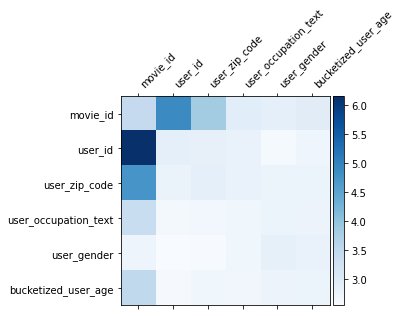

In [ ]:
model = dcn_result["model"][0]
mat = model._cross_layer._dense.kernel
features = model._all_features

block_norm = np.ones([len(features), len(features)])

dim = model.embedding_dimension

# Compute the norms of the blocks.
for i in range(len(features)):
  for j in range(len(features)):
    block = mat[i * dim:(i + 1) * dim,
                j * dim:(j + 1) * dim]
    block_norm[i,j] = np.linalg.norm(block, ord="fro")

plt.figure(figsize=(9,9))
im = plt.matshow(block_norm, cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
_ = ax.set_yticklabels([""] + features, fontsize=10)

That's all for this colab! We hope that you have enjoyed learning some basics of DCN and common ways to utilize it. If you are interested in learning more, you could check out two relevant papers: [DCN-v1-paper](https://arxiv.org/pdf/1708.05123.pdf), [DCN-v2-paper](https://arxiv.org/pdf/2008.13535.pdf).

---


##References
[DCN V2: Improved Deep & Cross Network and Practical Lessons for Web-scale Learning to Rank Systems](https://arxiv.org/pdf/2008.13535.pdf). \
*Ruoxi Wang, Rakesh Shivanna, Derek Zhiyuan Cheng, Sagar Jain, Dong Lin, Lichan Hong, Ed Chi. (2020)*


[Deep & Cross Network for Ad Click Predictions](https://arxiv.org/pdf/1708.05123.pdf). \
*Ruoxi Wang, Bin Fu, Gang Fu, Mingliang Wang. (AdKDD 2017)*

# Listwise ranking

In [the basic ranking tutorial](basic_ranking), we trained a model that can predict ratings for user/movie pairs. The model was trained to minimize the mean squared error of predicted ratings.

However, optimizing the model's predictions on individual movies is not necessarily the best method for training ranking models. We do not need ranking models to predict scores with great accuracy. Instead, we care more about the ability of the model to generate an ordered list of items that matches the user's preference ordering.

Instead of optimizing the model's predictions on individual query/item pairs, we can optimize the model's ranking of a list as a whole. This method is called _listwise ranking_.

In this tutorial, we will use TensorFlow Recommenders to build listwise ranking models. To do so, we will make use of ranking losses and metrics provided by [TensorFlow Ranking](https://github.com/tensorflow/ranking), a TensorFlow package that focuses on [learning to rank](https://www.microsoft.com/en-us/research/publication/learning-to-rank-from-pairwise-approach-to-listwise-approach/).

## Preliminaries

If TensorFlow Ranking is not available in your runtime environment, you can install it using `pip`:

In [ ]:
#!pip install -q tensorflow-recommenders
#!pip install -q --upgrade tensorflow-datasets
!pip install -q tensorflow-ranking

     |████████████████████████████████| 141 kB 12.5 MB/s 


We can then import all the necessary packages:

In [ ]:
import pprint

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
import tensorflow_ranking as tfr
import tensorflow_recommenders as tfrs

We will continue to use the MovieLens 100K dataset. As before, we load the datasets and keep only the user id, movie title, and user rating features for this tutorial. We also do some houskeeping to prepare our vocabularies.

In [ ]:
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
})
movies = movies.map(lambda x: x["movie_title"])

unique_movie_titles = np.unique(np.concatenate(list(movies.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(ratings.batch(1_000).map(
    lambda x: x["user_id"]))))

## Data preprocessing

However, we cannot use the MovieLens dataset for list optimization directly. To perform listwise optimization, we need to have access to a list of movies each user has rated, but each example in the MovieLens 100K dataset contains only the rating of a single movie.

To get around this we transform the dataset so that each example contains a user id and a list of movies rated by that user. Some movies in the list will be ranked higher than others; the goal of our model will be to make predictions that match this ordering.

To do this, we use the `tfrs.examples.movielens.movielens_to_listwise` helper function. It takes the MovieLens 100K dataset and generates a dataset containing list examples as discussed above. The implementation details can be found in the [source code](https://github.com/tensorflow/recommenders/blob/main/tensorflow_recommenders/examples/movielens.py).

In [ ]:
tf.random.set_seed(42)

# Split between train and tests sets, as before.
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

# We sample 50 lists for each user for the training data. For each list we
# sample 5 movies from the movies the user rated.
train = tfrs.examples.movielens.sample_listwise(
    train,
    num_list_per_user=50,
    num_examples_per_list=5,
    seed=42
)
test = tfrs.examples.movielens.sample_listwise(
    test,
    num_list_per_user=1,
    num_examples_per_list=5,
    seed=42
)

We can inspect an example from the training data. The example includes a user id, a list of 10 movie ids, and their ratings by the user.

In [ ]:
for example in train.take(1):
  pprint.pprint(example)

{'movie_title': <tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'Postman, The (1997)', b'Liar Liar (1997)', b'Contact (1997)',
       b'Welcome To Sarajevo (1997)',
       b'I Know What You Did Last Summer (1997)'], dtype=object)>,
 'user_id': <tf.Tensor: shape=(), dtype=string, numpy=b'681'>,
 'user_rating': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([4., 5., 1., 4., 1.], dtype=float32)>}


## Model definition

We will train the same model with three different losses: 

- mean squared error,
- pairwise hinge loss, and
- a listwise ListMLE loss. 

These three losses correspond to pointwise, pairwise, and listwise optimization.

To evaluate the model we use [normalized discounted cumulative gain (NDCG)](https://en.wikipedia.org/wiki/Discounted_cumulative_gain#Normalized_DCG). NDCG measures a predicted ranking by taking a weighted sum of the actual rating of each candidate. The ratings of movies that are ranked lower by the model would be discounted more. As a result, a good model that ranks highly-rated movies on top would have a high NDCG result. Since this metric takes the ranked position of each candidate into account, it is a listwise metric.

In [ ]:
class RankingModel(tfrs.Model):

  def __init__(self, loss):
    super().__init__()
    embedding_dimension = 32

    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids),
      tf.keras.layers.Embedding(len(unique_user_ids) + 2, embedding_dimension)
    ])

    # Compute embeddings for movies.
    self.movie_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 2, embedding_dimension)
    ])

    # Compute predictions.
    self.score_model = tf.keras.Sequential([
      # Learn multiple dense layers.
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(64, activation="relu"),
      # Make rating predictions in the final layer.
      tf.keras.layers.Dense(1)
    ])

    self.task = tfrs.tasks.Ranking(
      loss=loss,
      metrics=[
        tfr.keras.metrics.NDCGMetric(name="ndcg_metric"),
        tf.keras.metrics.RootMeanSquaredError()
      ]
    )

  def call(self, features):
    # We first convert the id features into embeddings.
    # User embeddings are a [batch_size, embedding_dim] tensor.
    user_embeddings = self.user_embeddings(features["user_id"])

    # Movie embeddings are a [batch_size, num_movies_in_list, embedding_dim]
    # tensor.
    movie_embeddings = self.movie_embeddings(features["movie_title"])
    
    # We want to concatenate user embeddings with movie emebeddings to pass
    # them into the ranking model. To do so, we need to reshape the user
    # embeddings to match the shape of movie embeddings.
    list_length = features["movie_title"].shape[1]
    user_embedding_repeated = tf.repeat(
        tf.expand_dims(user_embeddings, 1), [list_length], axis=1)

    # Once reshaped, we concatenate and pass into the dense layers to generate
    # predictions.
    concatenated_embeddings = tf.concat(
        [user_embedding_repeated, movie_embeddings], 2)
    
    return self.score_model(concatenated_embeddings)

  def compute_loss(self, features, training=False):
    labels = features.pop("user_rating")

    scores = self(features)

    return self.task(
        labels=labels,
        predictions=tf.squeeze(scores, axis=-1),
    )

## Training the models

We can now train each of the three models.

In [ ]:
epochs = 30

cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

### Mean squared error model

This model is very similar to the model in [the basic ranking tutorial](basic_ranking). We train the model to minimize the mean squared error between the actual ratings and predicted ratings. Therefore, this loss is computed individually for each movie and the training is pointwise.

In [ ]:
mse_model = RankingModel(tf.keras.losses.MeanSquaredError())
mse_model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [ ]:
mse_model.fit(cached_train, epochs=epochs, verbose=False)

### Pairwise hinge loss model

By minimizing the pairwise hinge loss, the model tries to maximize the difference between the model's predictions for a highly rated item and a low rated item: the bigger that difference is, the lower the model loss. However, once the difference is large enough, the loss becomes zero, stopping the model from further optimizing this particular pair and letting it focus on other pairs that are incorrectly ranked

This loss is not computed for individual movies, but rather for pairs of movies. Hence the training using this loss is pairwise.

In [ ]:
hinge_model = RankingModel(tfr.keras.losses.PairwiseHingeLoss())
hinge_model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [ ]:
hinge_model.fit(cached_train, epochs=epochs, verbose=False)

### Listwise model

The `ListMLE` loss from TensorFlow Ranking expresses list maximum likelihood estimation. To calculate the ListMLE loss, we first use the user ratings to generate an optimal ranking. We then calculate the likelihood of each candidate being out-ranked by any item below it in the optimal ranking using the predicted scores. The model tries to minimize such likelihood to ensure highly rated candidates are not out-ranked by low rated candidates. You can learn more about the details of ListMLE in section 2.2 of the paper [Position-aware ListMLE: A Sequential Learning Process](http://auai.org/uai2014/proceedings/individuals/164.pdf).

Note that since the likelihood is computed with respect to a candidate and all candidates below it in the optimal ranking, the loss is not pairwise but listwise. Hence the training uses list optimization.

In [ ]:
listwise_model = RankingModel(tfr.keras.losses.ListMLELoss())
listwise_model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [ ]:
listwise_model.fit(cached_train, epochs=epochs, verbose=False)

## Comparing the models

In [ ]:
mse_model_result = mse_model.evaluate(cached_test, return_dict=True)
print("NDCG of the MSE Model: {:.4f}".format(mse_model_result["ndcg_metric"]))

1/1 [==============================] - 0s 493ms/step - ndcg_metric: 0.9053 - root_mean_squared_error: 0.9671 - loss: 0.9353 - regularization_loss: 0.0000e+00 - total_loss: 0.9353
NDCG of the MSE Model: 0.9053


In [ ]:
hinge_model_result = hinge_model.evaluate(cached_test, return_dict=True)
print("NDCG of the pairwise hinge loss model: {:.4f}".format(hinge_model_result["ndcg_metric"]))

1/1 [==============================] - 1s 584ms/step - ndcg_metric: 0.9059 - root_mean_squared_error: 3.8332 - loss: 1.0179 - regularization_loss: 0.0000e+00 - total_loss: 1.0179
NDCG of the pairwise hinge loss model: 0.9059


In [ ]:
listwise_model_result = listwise_model.evaluate(cached_test, return_dict=True)
print("NDCG of the ListMLE model: {:.4f}".format(listwise_model_result["ndcg_metric"]))

1/1 [==============================] - 1s 544ms/step - ndcg_metric: 0.9070 - root_mean_squared_error: 2.7237 - loss: 4.5401 - regularization_loss: 0.0000e+00 - total_loss: 4.5401
NDCG of the ListMLE model: 0.9070


Of the three models, the model trained using ListMLE has the highest NDCG metric. This result shows how listwise optimization can be used to train ranking models and can potentially produce models that perform better than models optimized in a pointwise or pairwise fashion.

# Efficient serving using SCANN


[Retrieval models](https://www.tensorflow.org/recommenders/examples/basic_retrieval) are often built to surface a handful of top candidates out of millions or even hundreds of millions of candidates. To be able to react to the user's context and behaviour, they need to be able to do this on the fly, in a matter of milliseconds.

Approximate nearest neighbour search (ANN) is the technology that makes this possible. In this tutorial, we'll show how to use ScaNN - a state of the art nearest neighbour retrieval package - to seamlessly scale TFRS retrieval to millions of items.

## What is ScaNN?

ScaNN is a library from Google Research that performs dense vector similarity search at large scale. Given a database of candidate embeddings, ScaNN indexes these embeddings in a manner that allows them to be rapidly searched at inference time. ScaNN uses state of the art vector compression techniques and carefully implemented algorithms to achieve the best speed-accuracy tradeoff. It can greatly outperform brute force search while sacrificing little in terms of accuracy.

## Building a ScaNN-powered model

To try out ScaNN in TFRS, we'll build a simple MovieLens retrieval model, just as we did in the [basic retrieval](https://www.tensorflow.org/recommenders/examples/basic_retrieval) tutorial. If you have followed that tutorial, this section will be familiar and can safely be skipped.

To start, install TFRS and TensorFlow Datasets:

In [ ]:
#!pip install -q tensorflow-recommenders
#!pip install -q --upgrade tensorflow-datasets

We also need to install `scann`: it's an optional dependency of TFRS, and so needs to be installed separately.

In [ ]:
!pip install -q scann

     |████████████████████████████████| 10.9 MB 12.4 MB/s 


Set up all the necessary imports.

In [ ]:
from typing import Dict, Text

import os
import pprint
import tempfile

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
import tensorflow_recommenders as tfrs

And load the data:

In [ ]:
# Load the MovieLens 100K data.
ratings = tfds.load(
    "movielens/100k-ratings",
    split="train"
)

# Get the ratings data.
ratings = (ratings
           # Retain only the fields we need.
           .map(lambda x: {"user_id": x["user_id"], "movie_title": x["movie_title"]})
           # Cache for efficiency.
           .cache(tempfile.NamedTemporaryFile().name)
)

# Get the movies data.
movies = tfds.load("movielens/100k-movies", split="train")
movies = (movies
          # Retain only the fields we need.
          .map(lambda x: x["movie_title"])
          # Cache for efficiency.
          .cache(tempfile.NamedTemporaryFile().name))

Before we can build a model, we need to set up the user and movie vocabularies:

In [ ]:
user_ids = ratings.map(lambda x: x["user_id"])

unique_movie_titles = np.unique(np.concatenate(list(movies.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(user_ids.batch(1000))))

We'll also set up the training and test sets:

In [ ]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

### Model definition

Just as in the [basic retrieval](https://www.tensorflow.org/recommenders/examples/basic_retrieval) tutorial, we build a simple two-tower model.

In [ ]:
class MovielensModel(tfrs.Model):

  def __init__(self):
    super().__init__()

    embedding_dimension = 32

    # Set up a model for representing movies.
    self.movie_model = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      # We add an additional embedding to account for unknown tokens.
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])

    # Set up a model for representing users.
    self.user_model = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
        # We add an additional embedding to account for unknown tokens.
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Set up a task to optimize the model and compute metrics.
    self.task = tfrs.tasks.Retrieval(
      metrics=tfrs.metrics.FactorizedTopK(
        candidates=movies.batch(128).cache().map(self.movie_model)
      )
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["user_id"])
    # And pick out the movie features and pass them into the movie model,
    # getting embeddings back.
    positive_movie_embeddings = self.movie_model(features["movie_title"])

    # The task computes the loss and the metrics.

    return self.task(user_embeddings, positive_movie_embeddings, compute_metrics=not training)

### Fitting and evaluation

A TFRS model is just a Keras model. We can compile it:

In [ ]:
model = MovielensModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

Estimate it:

In [ ]:
model.fit(train.batch(8192), epochs=3)

Epoch 1/3
10/10 [==============================] - 1s 34ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 69808.9688 - regularization_loss: 0.0000e+00 - total_loss: 69808.9688
Epoch 2/3
10/10 [==============================] - 1s 32ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 67485.8842 - regularization_loss: 0.0000e+00 - total_loss: 67485.8842
Epoch 3/3
10/10 [==============================] - 1s 33ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - fact

And evaluate it.

In [ ]:
model.evaluate(test.batch(8192), return_dict=True)

3/3 [==============================] - 2s 314ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0012 - factorized_top_k/top_5_categorical_accuracy: 0.0091 - factorized_top_k/top_10_categorical_accuracy: 0.0222 - factorized_top_k/top_50_categorical_accuracy: 0.1262 - factorized_top_k/top_100_categorical_accuracy: 0.2365 - loss: 49466.8740 - regularization_loss: 0.0000e+00 - total_loss: 49466.8740


{'factorized_top_k/top_100_categorical_accuracy': 0.23645000159740448,
 'factorized_top_k/top_10_categorical_accuracy': 0.02215000055730343,
 'factorized_top_k/top_1_categorical_accuracy': 0.0012499999720603228,
 'factorized_top_k/top_50_categorical_accuracy': 0.1262499988079071,
 'factorized_top_k/top_5_categorical_accuracy': 0.009100000374019146,
 'loss': 28242.830078125,
 'regularization_loss': 0,
 'total_loss': 28242.830078125}

## Approximate prediction

The most straightforward way of retrieving top candidates in response to a query is to do it via brute force: compute user-movie scores for all possible movies, sort them, and pick a couple of top recommendations.

In TFRS, this is accomplished via the `BruteForce` layer:

In [ ]:
brute_force = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
brute_force.index_from_dataset(
    movies.batch(128).map(lambda title: (title, model.movie_model(title)))
)

Once created and populated with candidates (via the `index` method), we can call it to get predictions out:

In [ ]:
# Get predictions for user 42.
_, titles = brute_force(np.array(["42"]), k=3)

print(f"Top recommendations: {titles[0]}")

Top recommendations: [b'Homeward Bound: The Incredible Journey (1993)'
 b"Kid in King Arthur's Court, A (1995)" b'Rudy (1993)']


On a small dataset of under 1000 movies, this is very fast:

In [ ]:
%timeit _, titles = brute_force(np.array(["42"]), k=3)

100 loops, best of 5: 2.04 ms per loop


But what happens if we have more candidates - millions instead of thousands?

We can simulate this by indexing all of our movies multiple times:

In [ ]:
# Construct a dataset of movies that's 1,000 times larger. We 
# do this by adding several million dummy movie titles to the dataset.
lots_of_movies = tf.data.Dataset.concatenate(
    movies.batch(4096),
    movies.batch(4096).repeat(1_000).map(lambda x: tf.zeros_like(x))
)

# We also add lots of dummy embeddings by randomly perturbing
# the estimated embeddings for real movies.
lots_of_movies_embeddings = tf.data.Dataset.concatenate(
    movies.batch(4096).map(model.movie_model),
    movies.batch(4096).repeat(1_000)
      .map(lambda x: model.movie_model(x))
      .map(lambda x: x * tf.random.uniform(tf.shape(x)))
)

We can build a `BruteForce` index on this larger dataset:

In [ ]:
brute_force_lots = tfrs.layers.factorized_top_k.BruteForce()
brute_force_lots.index_from_dataset(
    tf.data.Dataset.zip((lots_of_movies, lots_of_movies_embeddings))
)

The recommendations are still the same

In [ ]:
_, titles = brute_force_lots(model.user_model(np.array(["42"])), k=3)

print(f"Top recommendations: {titles[0]}")

Top recommendations: [b'Homeward Bound: The Incredible Journey (1993)'
 b"Kid in King Arthur's Court, A (1995)" b'Rudy (1993)']


But they take much longer. With a candidate set of 1 million movies, brute force prediction becomes quite slow:

In [ ]:
%timeit _, titles = brute_force_lots(model.user_model(np.array(["42"])), k=3)

100 loops, best of 5: 4.16 ms per loop


As the number of candidate grows, the amount of time needed grows linearly: with 10 million candidates, serving top candidates would take 250 milliseconds. This is clearly too slow for a live service.

This is where approximate mechanisms come in.

Using ScaNN in TFRS is accomplished via the `tfrs.layers.factorized_top_k.ScaNN` layer. It follow the same interface as the other top k layers:

In [ ]:
!pip install scann

In [ ]:
scann = tfrs.layers.factorized_top_k.ScaNN(num_reordering_candidates=100)
scann.index_from_dataset(
    tf.data.Dataset.zip((lots_of_movies, lots_of_movies_embeddings))
)

ImportError: ignored

The recommendations are (approximately!) the same

In [ ]:
_, titles = scann(model.user_model(np.array(["42"])), k=3)

print(f"Top recommendations: {titles[0]}")

NameError: ignored

But they are much, much faster to compute:

In [ ]:
%timeit _, titles = scann(model.user_model(np.array(["42"])), k=3)

In this case, we can retrieve the top 3 movies out of a set of ~1 million in around 2 milliseconds: 15 times faster than by computing the best candidates via brute force. The advantage of approximate methods grows even larger for larger datasets.

## Evaluating the approximation

When using approximate top K retrieval mechanisms (such as ScaNN), speed of retrieval often comes at the expense of accuracy. To understand this trade-off, it's important to measure the model's evaluation metrics when using ScaNN, and to compare them with the baseline.

Fortunately, TFRS makes this easy. We simply override the metrics on the retrieval task with metrics using ScaNN, re-compile the model, and run evaluation.

To make the comparison, let's first run baseline results. We still need to override our metrics to make sure they are using the enlarged candidate set rather than the original set of movies:

In [ ]:
# Override the existing streaming candidate source.
model.task.factorized_metrics = tfrs.metrics.FactorizedTopK(
    candidates=lots_of_movies_embeddings
)
# Need to recompile the model for the changes to take effect.
model.compile()

%time baseline_result = model.evaluate(test.batch(8192), return_dict=True, verbose=False)

We can do the same using ScaNN:

In [ ]:
model.task.factorized_metrics = tfrs.metrics.FactorizedTopK(
    candidates=scann
)
model.compile()

# We can use a much bigger batch size here because ScaNN evaluation
# is more memory efficient.
%time scann_result = model.evaluate(test.batch(8192), return_dict=True, verbose=False)

ScaNN based evaluation is much, much quicker: it's over ten times faster! This advantage is going to grow even larger for bigger datasets, and so for large datasets it may be prudent to always run ScaNN-based evaluation to improve model development velocity.

But how about the results? Fortunately, in this case the results are almost the same:


In [ ]:
print(f"Brute force top-100 accuracy: {baseline_result['factorized_top_k/top_100_categorical_accuracy']:.2f}")
print(f"ScaNN top-100 accuracy:       {scann_result['factorized_top_k/top_100_categorical_accuracy']:.2f}")

This suggests that on this artificial datase,  there is little loss from the approximation. In general, all approximate methods exhibit speed-accuracy tradeoffs. To understand this in more depth you can check out Erik Bernhardsson's [ANN benchmarks](https://github.com/erikbern/ann-benchmarks).

## Deploying the approximate model

The `ScaNN`-based model is fully integrated into TensorFlow models, and serving it is as easy as serving any other TensorFlow model.

We can save it as a `SavedModel` object

In [ ]:
lots_of_movies_embeddings

In [ ]:
# We re-index the ScaNN layer to include the user embeddings in the same model.
# This way we can give the saved model raw features and get valid predictions
# back.
scann = tfrs.layers.factorized_top_k.ScaNN(model.user_model, num_reordering_candidates=1000)
scann.index_from_dataset(
    tf.data.Dataset.zip((lots_of_movies, lots_of_movies_embeddings))
)

# Need to call it to set the shapes.
_ = scann(np.array(["42"]))

with tempfile.TemporaryDirectory() as tmp:
  path = os.path.join(tmp, "model")
  tf.saved_model.save(
      scann,
      path,
      options=tf.saved_model.SaveOptions(namespace_whitelist=["Scann"])
  )

  loaded = tf.saved_model.load(path)

and then load it and serve, getting exactly the same results back:

In [ ]:
_, titles = loaded(tf.constant(["42"]))

print(f"Top recommendations: {titles[0][:3]}")

The resulting model can be served in any Python service that has TensorFlow and ScaNN installed.

It can also be served using a customized version of TensorFlow Serving, available as a Docker container on [Docker Hub](https://hub.docker.com/r/google/tf-serving-scann). You can also build the image yourself from the [Dockerfile](https://github.com/google-research/google-research/tree/master/scann/tf_serving).

## Tuning ScaNN

Now let's look into tuning our ScaNN layer to get a better performance/accuracy tradeoff. In order to do this effectively, we first need to measure our baseline performance and accuracy.

From above, we already have a measurement of our model's latency for processing a single (non-batched) query (although note that a fair amount of this latency is from non-ScaNN components of the model).

Now we need to investigate ScaNN's accuracy, which we measure through recall. A recall@k of x% means that if we use brute force to retrieve the true top k neighbors, and compare those results to using ScaNN to also retrieve the top k neighbors, x% of ScaNN's results are in the true brute force results. Let's compute the recall for the current ScaNN searcher.

First, we need to generate the brute force, ground truth top-k:

In [ ]:
# Process queries in groups of 1000; processing them all at once with brute force
# may lead to out-of-memory errors, because processing a batch of q queries against
# a size-n dataset takes O(nq) space with brute force.
titles_ground_truth = tf.concat([
  brute_force_lots(queries, k=10)[1] for queries in
  test.batch(1000).map(lambda x: model.user_model(x["user_id"]))
], axis=0)

Our variable `titles_ground_truth` now contains the top-10 movie recommendations returned by brute-force retrieval. Now we can compute the same recommendations when using ScaNN:

In [ ]:
# Get all user_id's as a 1d tensor of strings
test_flat = np.concatenate(list(test.map(lambda x: x["user_id"]).batch(1000).as_numpy_iterator()), axis=0)

# ScaNN is much more memory efficient and has no problem processing the whole
# batch of 20000 queries at once.
_, titles = scann(test_flat, k=10)

Next, we define our function that computes recall. For each query, it counts how many results are in the intersection of the brute force and the ScaNN results and divides this by the number of brute force results. The average of this quantity over all queries is our recall.

In [ ]:
def compute_recall(ground_truth, approx_results):
  return np.mean([
      len(np.intersect1d(truth, approx)) / len(truth)
      for truth, approx in zip(ground_truth, approx_results)
  ])

This gives us baseline recall@10 with the current ScaNN config:

In [ ]:
print(f"Recall: {compute_recall(titles_ground_truth, titles):.3f}")

We can also measure the baseline latency:

In [ ]:
%timeit -n 1000 scann(np.array(["42"]), k=10)

Let's see if we can do better!

To do this, we need a model of how ScaNN's tuning knobs affect performance. Our current model uses ScaNN's tree-AH algorithm. This algorithm partitions the database of embeddings (the "tree") and then scores the most promising of these partitions using AH, which is a highly optimized approximate distance computation routine.

The default parameters for TensorFlow Recommenders' ScaNN Keras layer sets `num_leaves=100` and `num_leaves_to_search=10`. This means our database is partitioned into 100 disjoint subsets, and the 10 most promising of these partitions is scored with AH. This means 10/100=10% of the dataset is being searched with AH.

If we have, say, `num_leaves=1000` and `num_leaves_to_search=100`, we would also be searching 10% of the database with AH. However, in comparison to the previous setting, the 10% we would search will contain higher-quality candidates, because a higher `num_leaves` allows us to make finer-grained decisions about what parts of the dataset are worth searching.

It's no surprise then that with `num_leaves=1000` and `num_leaves_to_search=100` we get significantly higher recall:

In [ ]:
scann2 = tfrs.layers.factorized_top_k.ScaNN(
    model.user_model, 
    num_leaves=1000,
    num_leaves_to_search=100,
    num_reordering_candidates=1000)
scann2.index_from_dataset(
    tf.data.Dataset.zip((lots_of_movies, lots_of_movies_embeddings))
)

_, titles2 = scann2(test_flat, k=10)

print(f"Recall: {compute_recall(titles_ground_truth, titles2):.3f}")

However, as a tradeoff, our latency has also increased. This is because the partitioning step has gotten more expensive; `scann` picks the top 10 of 100 partitions while `scann2` picks the top 100 of 1000 partitions. The latter can be more expensive because it involves looking at 10 times as many partitions.

In [ ]:
%timeit -n 1000 scann2(np.array(["42"]), k=10)

In general, tuning ScaNN search is about picking the right tradeoffs. Each individual parameter change generally won't make search both faster and more accurate; our goal is to tune the parameters to optimally trade off between these two conflicting goals.

In our case, `scann2` significantly improved recall over `scann` at some cost in latency. Can we dial back some other knobs to cut down on latency, while preserving most of our recall advantage?

Let's try searching 70/1000=7% of the dataset with AH, and only rescoring the final 400 candidates:

In [ ]:
scann3 = tfrs.layers.factorized_top_k.ScaNN(
    model.user_model,
    num_leaves=1000,
    num_leaves_to_search=70,
    num_reordering_candidates=400)
scann3.index_from_dataset(
    tf.data.Dataset.zip((lots_of_movies, lots_of_movies_embeddings))
)

_, titles3 = scann3(test_flat, k=10)
print(f"Recall: {compute_recall(titles_ground_truth, titles3):.3f}")

`scann3` delivers about a 3% absolute recall gain over `scann` while also delivering lower latency:

In [ ]:
%timeit -n 1000 scann3(np.array(["42"]), k=10)

These knobs can be further adjusted to optimize for different points along the accuracy-performance pareto frontier. ScaNN's algorithms can achieve state-of-the-art performance over a wide range of recall targets.

## Further reading

ScaNN uses advanced vector quantization techniques and highly optimized implementation to achieve its results. The field of vector quantization has a rich history with a variety of approaches. ScaNN's current quantization technique is detailed in [this paper](https://arxiv.org/abs/1908.10396), published at ICML 2020. The paper was also released along with [this blog article](https://ai.googleblog.com/2020/07/announcing-scann-efficient-vector.html) which gives a high level overview of our technique.

Many related quantization techniques are mentioned in the references of our ICML 2020 paper, and other ScaNN-related research is listed at http://sanjivk.com/.